In [43]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import h5py
from scipy import io
from scipy import signal
import os
import glob
import csv
from biosppy.signals import ecg
from sklearn.preprocessing import LabelEncoder

preparing data for training

In [13]:
arr = []
with open('training2017/REFERENCE.csv', newline='') as csvfile:
     spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
     for row in spamreader:
        
         spam = row[0].split(',')
         if spam[1] == 'A':
            
            arr.append(spam[0])
print (len(arr))            

738


(972, 512, 1)
(1944,) 108


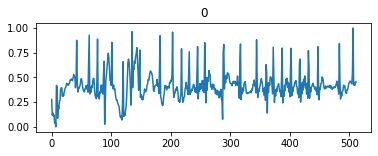

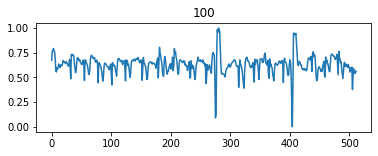

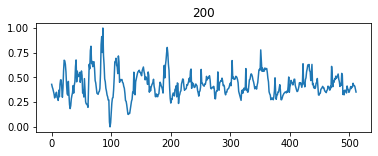

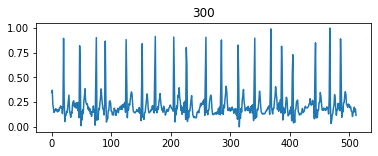

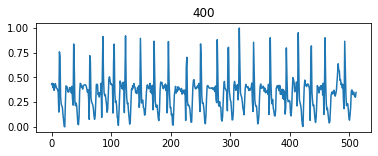

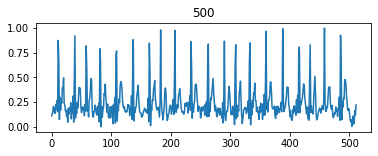

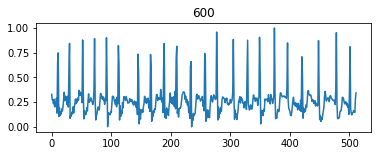

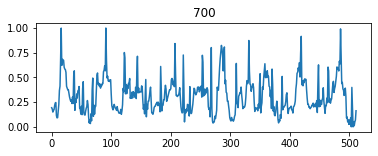

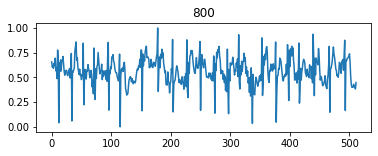

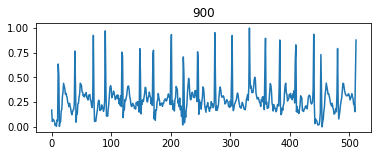

In [53]:
l = 738 
d = 9000
r = 1024
w = 512
st = 30
hwm = 32
data = []
length = []
hrm = []
hrv = []
c = 90
cc = 90
cl = 0.6
ccll = 0.6
rmin = 65
rmax = 75
db = io.loadmat('training2017/' + arr[400]) 
dummy = db['val'][0, :]
out = ecg.ecg(signal=dummy, sampling_rate=300., show=False)
temp = out['templates'][0]
for i in range(l):
    
    db = io.loadmat('training2017/' + arr[i]) 
    dummy = db['val'][0, :]
    out = ecg.ecg(signal=dummy, sampling_rate=300., show=False)
    length.append(len(dummy))
    min = np.amin(dummy)
    max = np.amax(dummy)
    if len(dummy) < 9000:
        
        dummy = np.append(dummy, dummy)
        dummy = np.append(dummy, dummy)
    dummy = dummy[0:d]    
    L = np.where(dummy >= cl*max)
    LL = np.where(dummy <= ccll*min)
    go = np.correlate(temp, out['templates'][0])
    if len(L[0]) > c and len(LL[0]) > cc and np.amin(out['heart_rate']) < rmax and np.amin(out['heart_rate']) > rmin and np.amax(go) > 0.9:
        
       dummy = signal.resample(dummy, r)
       for j in range(hwm):
        
            if j*st+w >= len(dummy):
            
                break;
            min = np.amin(dummy[j*st:j*st+w])
            max = np.amax(dummy[j*st:j*st+w])
            ddata = (dummy[j*st:j*st+w]-min)/(max-min)
            hrm.append(np.mean(out['heart_rate']))
            hrv.append(np.var(out['heart_rate']))            
            data.append(ddata) 
data = np.asarray(data).reshape(len(data), w, 1)
hrm = np.asarray(hrm).reshape(len(data))
hrv = np.asarray(hrv).reshape(len(data))
hr = np.append(hrm, hrv, axis=0)
seq_in = np.copy(data)
print (seq_in.shape)  
encoder = LabelEncoder()
encoder.fit(hr)
hr = encoder.transform(hr)
print (hr.shape, len(np.unique(hr)))  
#print (length)
for i in range(0, len(seq_in), 100):
    
    plt.figure(figsize=(6, 2))
    plt.plot(seq_in[i, :, 0])
    plt.title(np.str(i))

GANLSTM for ECG data

In [54]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Reshape, Dropout, LSTM, Bidirectional, ConvLSTM2D, MaxPooling1D, Conv1D, Flatten, UpSampling1D, ZeroPadding1D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, RepeatVector, Embedding, multiply
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.utils import np_utils
from keras.utils import plot_model
from keras.regularizers import l1_l2
import keras.backend as K
from keras.models import model_from_json

In [57]:
class GAN():
    def __init__(self, rows, channels, classes):
        
        self.seq_length = rows
        self.channels = channels
        self.latent_dim = 100
        self.critic_loss = []
        self.gen_loss = []
        self.clip_value = 0.1
        self.n_critic = 5   
        self.num_classes = classes
        optimizer_c = Adam(0.0002, 0.5)
        optimizer_g = Adam(0.0004, 0.5)
        
        self.critic = self.build_critic()
        self.critic.compile(loss='binary_crossentropy', optimizer=optimizer_c, metrics=['accuracy'])

        self.generator = self.build_generator()
                
        z = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        generated_seq = self.generator([z, label])
        self.critic.trainable = False
        validity = self.critic([generated_seq, label])
        self.combined = Model([z, label], validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer_g)

    def build_critic(self):

        model = Sequential()           
        model.add(Conv1D(filters=16, kernel_size=3, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Conv1D(filters=32, kernel_size=3, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dropout(0.4))    
        model.add(Conv1D(filters=64, kernel_size=3, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dropout(0.4)) 
        model.add(Conv1D(filters=128, kernel_size=3, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dropout(0.4))        
        model.add(Flatten())         
        model.add(Dense(1, activation='sigmoid'))
        
        seq = Input(shape=(self.seq_length, self.channels))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.seq_length)(label))
        model_input = multiply([seq, label_embedding])
        
        validity = model(model_input)

        return Model([seq, label], validity)
      
    def build_generator(self):

        model = Sequential()      
        l = np.int(self.seq_length/16.0)
        model.add(Dense(l*128, activation='relu', input_dim=self.latent_dim))
        model.add(Reshape((l, 128)))
        model.add(UpSampling1D(2))
        model.add(Conv1D(128, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))
        model.add(UpSampling1D(2))
        model.add(Conv1D(64, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))        
        model.add(UpSampling1D(2))
        model.add(Conv1D(32, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))
        model.add(UpSampling1D(2))
        model.add(Conv1D(16, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))        
        model.add(Conv1D(self.channels, kernel_size=6, padding='same'))
        model.add(Activation('sigmoid'))        
        
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        model_input = multiply([noise, label_embedding])
        seq = model(model_input)

        return Model([noise, label], seq)

    def train(self, epochs, batch_size=64, sample_interval=10):

        X_train = seq_in      
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            
            for _ in range(self.n_critic):
                
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                real_seqs = X_train[idx]
                label = hr[idx]
                
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim)) 
                gen_seqs = self.generator.predict([noise, label])            

                d_loss_real = self.critic.train_on_batch([real_seqs, label], real)
                d_loss_fake = self.critic.train_on_batch([gen_seqs, label], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                for l in self.critic.layers:
                    
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)

            g_loss = self.combined.train_on_batch([noise, label], real)

            if epoch % sample_interval == 0:
                
              print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
              self.critic_loss.append(d_loss[0])
              self.gen_loss.append(g_loss)
        self.plot_loss()            
            
    def plot_loss(self):
        
        plt.plot(self.critic_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['critic', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.close()            

In [ ]:
gan = GAN(rows=seq_in.shape[1], channels=seq_in.shape[2], classes=len(np.unique(hr)))    
gan.train(epochs=10000, batch_size=64, sample_interval=100)

/home/lolo/miniconda3/envs/dnnComm/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.698589] [G loss: 0.700898]


/home/lolo/miniconda3/envs/dnnComm/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


generate synthetic ecg

In [ ]:
noise = np.random.normal(0, 1, (2, gan.latent_dim))
gen_seqs = gan.generator.predict([noise, hr[0]]).reshape(2, gan.seq_length)
plt.figure(figsize=(6, 2))
plt.plot(gen_seqs[0])
plt.figure(figsize=(6, 2))
plt.plot(gen_seqs[1])

In [ ]:
model = gan.generator
model_json = model.to_json()
with open("gan.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("gan.h5")
print("Saved model to disk")

In [ ]:
json_file = open('gan.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("gan.h5")
print("Loaded model from disk")

In [ ]:
noise = np.random.normal(0, 1, (2, gan.latent_dim))
gen_seqs = loaded_model.predict([noise, hr[0]]).reshape(2, gan.seq_length)
plt.figure(figsize=(6, 2))
plt.plot(gen_seqs[0])
plt.figure(figsize=(6, 2))
plt.plot(gen_seqs[1])